<a href="https://colab.research.google.com/github/33quitykubby/Rabbit_DNN_1_2/blob/main/Rabbit_DNN_7_newtwork1_optimize_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2層DNN

サンプルコード2_1_network_modified.ipynb
写経  
最適化アルゴリズムにAdamを使う


# 日本時間にする

In [ ]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Wed Apr 28 22:17:28 JST 2021


# ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

from sklearn.datasets import load_boston
from pandas import DataFrame

In [ ]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-04-28 22:17:28.266144+09:00


# 乱数シードの初期化






In [ ]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
#乱数シード固定

seed_everything()

# パス定義

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## class Relu

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None
  
  def forward(self, x):
    self.mask = ( x <= 0 )
    out = x.copy()
    # Trueの箇所を0にする
    out[self.mask] = 0
  
    return out

  def backward(self, dout):
    self.mask = ( dout > 0)
    out = dout.copy()
    # Trueの箇所を0にする
    dout[self.mask] = 0
    dx = dout

    return dx
  



## class Affine（全結合層）

$$dout = x・W + b$$

In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.original_x_shape = None
    
    #重み、バイアスの微分
    self.dW = None
    self.db = None
  
  def forward(self, x):
    #　テンソル対応
    self.original_x_shape = x.shape
    # print("x.org.shape=",self.original_x_shape)
    x = x.reshape(x.shape[0], -1)
    self.x = x
    # print("x.shape=",self.x.shape)

    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout,axis=0)

    # 入力データの形状にもどしてあげる
    dx = dx.reshape(*self.original_x_shape)
    return dx


## class SoftmaxWithLoss

In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.d = None

  def softmax(self, x):
    if x.ndim == 2:
      x = x.T
      x = x - np.max(x, axis=0)
      y = np.exp(x) / np.sum(np.exp(x), axis=0)
      return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

  def cross_entropy_error(self, d, y):
    if y.ndim == 1:
      d = d.reshape(1, d.size)
      y = y.reshape(1, y.size)

    #教師データがone-hotの場合、正解ラベルのインデックスに変換
    if d.size == y.size:
      d = d.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size

  def forward(self, x, d):
    self.d = d
    self.y = self.softmax(x)
    self.loss = self.cross_entropy_error(self.d, self.y)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.d.shape[0]
    if self.d.size == self.y.size: # 教師データがone-hotの場合
      dx = (self.y - self.d) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.d] -= 1
      dx = dx / batch_size

    return dx

# 2層DNN

In [ ]:
import collections

class TwoLayerNet:

  #input_size 入力層のノード数
  # hidden_size:隠れ層のノード数
  # output_size:出力層のノード数
  # weight_init_std:重みの初期化方法

  def __init__(self, input_size, hidden_size, output_size, weight_init_std =0.01):
    #重みの初期化
    self.params={}
    self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['b2'] = np.zeros(output_size)

    #レイヤの生成
    self.layers = collections.OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

  #順伝播
  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  #誤差
  def loss(self, x, d):
    y = self.predict(x)
    return self.lastLayer.forward(y, d)

  #精度
  def accuracy(self, x, d):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 :
      d = np.argmax(d, axis=1)

    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

  # 勾配
  def gradient(self, x, d):
    #forward
    self.loss(x, d)

    #backward
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    #設定
    grad = {}
    grad['W1'], grad['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db 
    grad['W2'], grad['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db 

    return grad

# MNISTデータ読み込み

In [ ]:
import gzip
import pickle

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = '/content/drive/MyDrive/RabbitChallenge/DNN_code_colab_lesson_1_2/data'
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


# MNIST Sample

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("data read finish")

network = TwoLayerNet(input_size=784, hidden_size=40, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 500
learning_rate = 0.0001

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

# v初期化
v= {}
m= {}
for key in ('W1', 'W2', 'b1', 'b2'):
  m[key] = 0 # 
  v[key] = 0 # 

beta1 = 0.001
beta2 = 0.001

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)

  for key in ('W1', 'W2', 'b1', 'b2'):
    m[key] += (1-beta1) * (grad[key] - m[key]) # Adam
    v[key] += (1-beta2) * (grad[key]**2 - v[key]) # Adam
    network.params[key] -= (learning_rate * m[key]) / np.sqrt(v[key] + 1e-7)

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)

  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: ' + str(i+1)+ ' Accuracy(Training)=' + str(accr_train))
    print('             :'+ str(i+1)+ ' Accuracy(Test)=' + str(accr_test))

data read finish
Generation: 10 Accuracy(Training)=0.096
             :10 Accuracy(Test)=0.0887
Generation: 20 Accuracy(Training)=0.12
             :20 Accuracy(Test)=0.1059
Generation: 30 Accuracy(Training)=0.098
             :30 Accuracy(Test)=0.0991
Generation: 40 Accuracy(Training)=0.112
             :40 Accuracy(Test)=0.098
Generation: 50 Accuracy(Training)=0.09
             :50 Accuracy(Test)=0.098
Generation: 60 Accuracy(Training)=0.112
             :60 Accuracy(Test)=0.098
Generation: 70 Accuracy(Training)=0.09
             :70 Accuracy(Test)=0.098
Generation: 80 Accuracy(Training)=0.102
             :80 Accuracy(Test)=0.098
Generation: 90 Accuracy(Training)=0.112
             :90 Accuracy(Test)=0.098
Generation: 100 Accuracy(Training)=0.104
             :100 Accuracy(Test)=0.098
Generation: 110 Accuracy(Training)=0.08
             :110 Accuracy(Test)=0.098
Generation: 120 Accuracy(Training)=0.09
             :120 Accuracy(Test)=0.098
Generation: 130 Accuracy(Training)=0.09
   

# `グラフ表示`

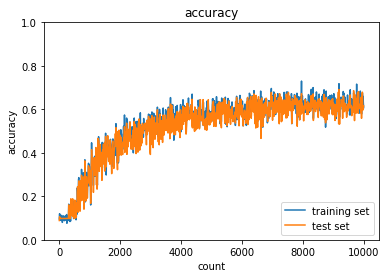

In [ ]:

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

# 終わり

In [ ]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-04-28 22:20:56.850096+09:00
total_time= 0:03:28.583952
